# Practice Session 03: Recommendation engines (Content-based)

Author: <font color="blue">Marc Pérez Pratdesaba</font>

E-mail: <font color="blue">marc.perez12@estudiant.upf.edu</font>

Date: <font color="blue">13/11/2022</font>

For this assignment we will build and use a content-based recommender system for movies. This content-based recommender will take as input a database of users and ratings on movies.


In [79]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [80]:
FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags-2000s.csv"


In [81]:
# Importing the datasets

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


In [82]:
# Method to get the year of a film

def yearof(title):
    split1 = title.split("(")
    year = ""
    for i in split1:
        split2 = i.split(")")
        for j in split2:
            if j.isdigit(): #Checking if char is a numerical digit
                return int(j)     

movies["year"] = movies.apply(lambda x: yearof(x['title']), axis=1) #Adding the column "year" in the dataframe

# Example usage function
print(yearof("The Emoji Movie (2017)"))

2017


To join ratings_raw and users we would use the "user_id" column, since it uniquely identify users for both dataframes.
Following this, we can join ratings_raw and users using the "movie_id" column, since both dataframes have it.

In [83]:
ratings = pd.merge(movies, ratings_raw, how = 'inner', on = 'movie_id')
display(ratings.head(5))

,movie_id,title,genres,year,user_id,rating
0,2769,"Yards, The (2000)",Crime|Drama,2000,1115,4.0
1,2769,"Yards, The (2000)",Crime|Drama,2000,1209,2.0
2,2769,"Yards, The (2000)",Crime|Drama,2000,2004,3.0
3,2769,"Yards, The (2000)",Crime|Drama,2000,2502,4.0
4,2769,"Yards, The (2000)",Crime|Drama,2000,2827,4.0


In [84]:
# Method to find movies given a keyword

def find_movies(keyword, movies):
    for title in movies.title:
        if keyword in title:
            row = movies[movies['title'] == title].index[0] # Getting the row
            print(f"movie_id: {movies.movie_id.loc[row]}, title: {title}") # Retrieving the movie_id and the title
            
find_movies("Barcelona", movies)

movie_id: 60950, title: Vicky Cristina Barcelona (2008)
movie_id: 182911, title: Barcelona Christmas Night (2015)


# 2. Exploratory Data Analysis

## 2.1. "Ratings" variable

In [85]:
ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

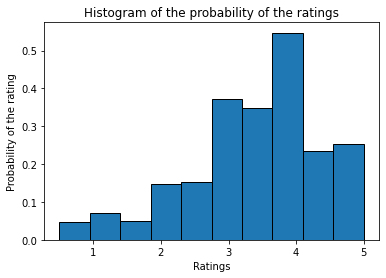

In [86]:
ratings_arr = np.array(ratings.rating) # Converting the column rating from ratings to an array
    
plt.hist(ratings_arr, edgecolor = "Black", density = "True") # To get the probability, we set "density" to True
plt.xlabel('Ratings')
plt.ylabel('Probability of the rating')
plt.title('Histogram of the probability of the ratings')
plt.show()


What we can observe in the distribution of ratings is a left-skewed distribution. In this way, people mostly rates a movie higher than lower. Following this, we could maybe consider that people only makes the effort to rate when they liked the movie.
Furthermore, we can observe that there are many more 4.5/5 rating than 0.5/1. This would maybe not be very intuitive, but it is significant.

In [87]:
good_ratings = ratings[ratings.rating > 4.0] # I have considered strictly greater than 4 (>)
bad_ratings = ratings[ratings.rating < 2.0] # I have considered strictly smaller than 2 (<)

print("Top 10 Movies with most good ratings:\n")
print(good_ratings.title.value_counts().nlargest(10))
print("\nTop 10 Movies with most bad ratings:\n")
print(bad_ratings.title.value_counts().nlargest(10))

Top 10 Movies with most good ratings:

Lord of the Rings: The Fellowship of the Ring, The (2001)    3017
Lord of the Rings: The Return of the King, The (2003)        2792
Lord of the Rings: The Two Towers, The (2002)                2690
Memento (2000)                                               2184
Gladiator (2000)                                             1835
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)        1801
Eternal Sunshine of the Spotless Mind (2004)                 1711
Spirited Away (Sen to Chihiro no kamikakushi) (2001)         1378
Kill Bill: Vol. 1 (2003)                                     1360
Shrek (2001)                                                 1311
Name: title, dtype: int64

Top 10 Movies with most bad ratings:

Charlie's Angels (2000)                                      338
Battlefield Earth (2000)                                     317
Scary Movie (2000)                                           296
Star Wars: Episode II - Attack of the Clo

What we can observe is that there are a lot more good ratings than bad ones. We can link this information with the plot we made above, which showed that people tend to rate more with good ratings than bad.
Also, we can observe that there are two movies that are present in both top 10: two movies from the Lord of the Rings. This may have happened because such popular movies have lots of good ratings, but also lots of bad ones (given the amount of people that watched them).

## 2.2. Genres distribution

In [88]:
list_genres = []

for genre in movies.genres:
    genre_split = genre.split("|")
    for gen in genre_split:
        if gen not in list_genres:
            list_genres.append(gen)
            
print(list_genres, "\n")
print(f'Number of genres: {len(list_genres) - 1}') # I have not considered "(no genres listed)" a genre. Hence, I substracted it from the length.

['Crime', 'Drama', 'Comedy', 'Adventure', 'Sci-Fi', 'Thriller', 'Romance', 'Horror', 'Mystery', 'Action', 'Animation', 'Children', 'Documentary', 'War', 'Musical', 'Western', 'Fantasy', 'IMAX', 'Film-Noir', '(no genres listed)'] 

Number of genres: 19


In [89]:
def generate_occurrences(movies):
    d_list_frequencies = {}

    for genre in movies.genres:
        genre_split = genre.split("|")
        for gen in genre_split:
            d_list_frequencies[gen] = d_list_frequencies.get(gen, 0) + 1

    d_list_frequencies_sorted = dict(sorted(d_list_frequencies.items(), key=lambda x:x[1], reverse = True))

    keyword_occurences = []
    for item in d_list_frequencies_sorted.items():
        keyword_occurences.append(list(item)) # Convert it to list because "item" is a tuple
    return keyword_occurences

keyword_occurences = generate_occurrences(movies) # Generate the occurrences for the dataset movies
print(keyword_occurences)

[['Drama', 13666], ['Comedy', 8898], ['Thriller', 5437], ['Documentary', 4473], ['Action', 3901], ['Romance', 3846], ['Horror', 3431], ['Crime', 2425], ['(no genres listed)', 2200], ['Sci-Fi', 1907], ['Adventure', 1906], ['Children', 1639], ['Animation', 1553], ['Mystery', 1516], ['Fantasy', 1456], ['War', 679], ['Musical', 308], ['Western', 194], ['IMAX', 173], ['Film-Noir', 21]]


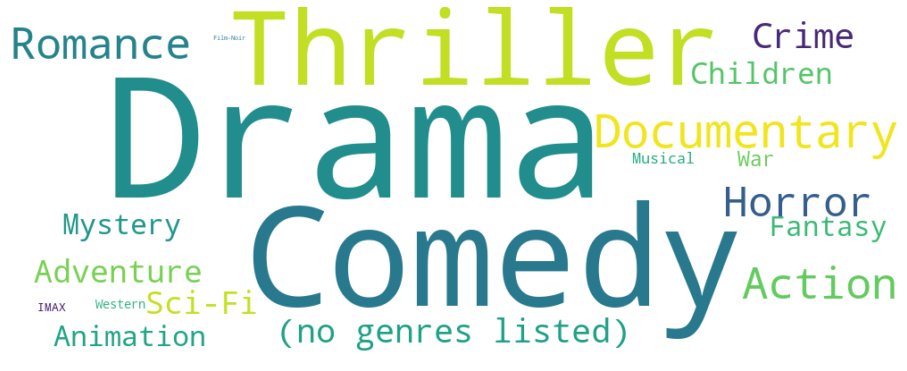

In [90]:
# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Cloud movies before 2010: 


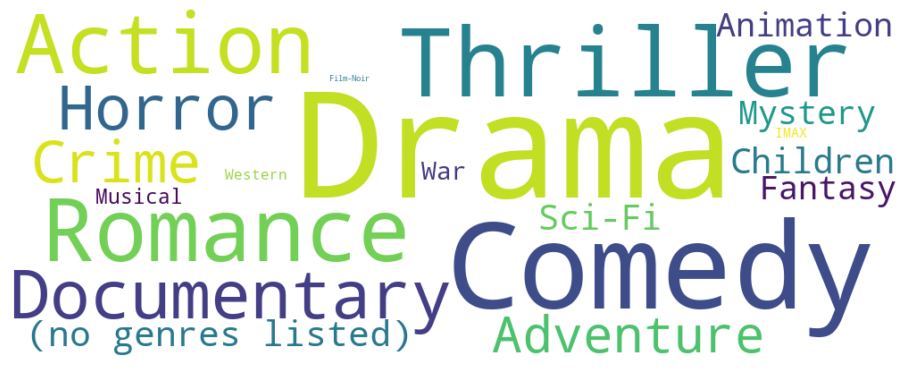




Cloud movies after 2010: 


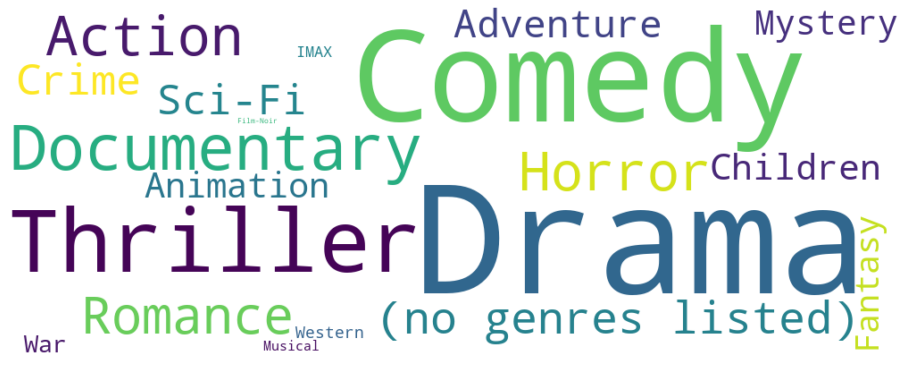

In [91]:
movies_before_2010 = movies[movies.year <= 2010] #Including 2010
movies_after_2010 = movies[movies.year > 2010] #Excluding 2010

key_occurrences_before_2010 = generate_occurrences(movies_before_2010)
key_occurrences_after_2010 = generate_occurrences(movies_after_2010)

# Generating cloud before 2010
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(key_occurrences_before_2010))

# Plot the word cloud
print("Cloud movies before 2010: ")
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("\n\n")
# Generating cloud after 2010
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(key_occurrences_after_2010))

# Plot the word cloud
print("Cloud movies after 2010: ")
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The main differences we can observe are that movies after 2010 have a preference for drama, comedy and Thriller, but film genres before 2010 are more or less equally distributed. Following this, we could relate these maps with the tendency for the cinema industry to bet only on what they believe will be popular, making the cinematic scene more plain and homogeneous.
An example of this would be the Marvel Cinematic Universe, which is the last years have been growing in popularity.
People nowadays maybe just want to see what is trendy, and what it is talked about on the internet.
On the other hand, in the past, directors and people were trying different genres and film formats than nowadays.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

In [92]:
genres_array = []
for genre in movies.genres:
    genres_array.append(genre.split("|"))

movies["genres_arr"] = genres_array
movies["genres_arr"] = movies["genres_arr"].fillna('').astype('str')
display(movies.head(5))

,movie_id,title,genres,year,genres_arr
0,2769,"Yards, The (2000)",Crime|Drama,2000,"['Crime', 'Drama']"
1,3177,Next Friday (2000),Comedy,2000,['Comedy']
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000,"['Adventure', 'Sci-Fi', 'Thriller']"
3,3225,Down to You (2000),Comedy|Romance,2000,"['Comedy', 'Romance']"
4,3228,Wirey Spindell (2000),Comedy,2000,['Comedy']


In [93]:
print("Transformed: %s → %s" % (movies['genres'][2], movies['genres_arr'][2]))

Transformed: Adventure|Sci-Fi|Thriller → ['Adventure', 'Sci-Fi', 'Thriller']


In [94]:
# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year > 2015]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,['(no genres listed)']
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"['Action', 'Adventure', 'Fantasy']"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,['(no genres listed)']
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"['Action', 'Adventure', 'Sci-Fi']"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"['Action', 'Adventure', 'Comedy', 'Sci-Fi']"


In [95]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english') # We create the vectorizer

tfidf_matrix = vectorizer.fit_transform(movies_filtered["genres_arr"]) # We genrate the tfidf matrix

print(tfidf_matrix.shape)

(7890, 128)


## 3.2. Calculate most similar movies

In [96]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [97]:
# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)

0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

0.492 164179 Arrival (2016)
0.301 164181 Samurai Rauni Reposaarelainen (2016)
0.000 164187 Rumbos (2016)
0.051 164189 Traceroute (2016)
0.000 164196 I, Olga Hepnarova (2016)
0.044 164200 Storks (2016)
0.000 164204 After the Storm (2016)
0.000 164218 Hurok (2016)
0.178 164222 I am not Salvador (2016)
0.628 164226 Maximum Ride (2016)
0.178 164228 Radin ! (2016)
0.000 164236 Sieranevada (2016)
0.000 164238 Dogs (2016)
0.087 164260 Horace and Pete (2016)
0.000 164262 The Man from Mo'Wax (2016)
0.000 164264 Audrie & Daisy (2016)
0.178 164268 Iliza Shlesinger: Confirmed Kills (2016)
0.000 164280 Endless Poetry (2016)
0.000 164365 Level Up (2016)
0.266 164367 The Girl with All the Gifts (2016)
0.087 164369 The Distinguished Citizen (2016)
0.000 164373 Abattoir (2016)
0.178 164375 All Roads Lead to Rome (2016)
0.000 164377 Inside or Outside (2016)
0.720 164379 Bounty Hunters (2016)
0.072 164381 Tik Tok (2016)
0.000 164387 Maigret Sets A Trap (2016)
0.238 164391 The Bodyguard (2016)
0.179 16439

0.000 168050 Late Bloomer (2016)
0.000 168052 Sleigh Bells Ring (2016)
0.075 168058 The King's Choice (2016)
0.000 168060 Rings (2017)
0.000 168062 The Barn (2016)
0.238 168064 Sword Master (2016)
0.000 168090 Kizumonogatari II: Passionate Blood (2016)
0.000 168122 Raw (2017)
0.000 168126 Clinical (2017)
0.000 168130 Teenage Cocktail (2016)
0.000 168136 Sold (2016)
0.143 168150 Legends of the Hidden Temple (2016)
0.000 168154 We Are the Flesh (2016)
0.000 168156 Deserted Cities (2016)
0.178 168174 Jim Gaffigan: Cinco (2017)
0.087 168184 Welcome to Norway (2016)
0.000 168202 Men Go to Battle (2016)
0.178 168204 Eu Fico Loko (2017)
0.000 168210 Staying Vertical (2016)
0.000 168214 The Crash (2017)
0.000 168218 Kizumonogatari III: Cold Blood (2017)
0.178 168224 Minha MÃ£e Ã© Uma PeÃ§a 2 (2016)
0.178 168226 Scrappin' (2016)
0.000 168236 To Be a Miss (2016)
0.000 168240 Afterimage (2017)
0.000 168242 I'm a Killer (2016)
0.000 168244 Maigret's Dead Man (2016)
0.301 168246 ISRA 88 (2016)
0.08

0.000 171127 The Irresistible Blueberry Farm (2016)
0.000 171129 Tommy's Honour (2016)
0.000 171131 My Way: The Rise and Fall of Silvio Berlusconi (2016)
0.000 171141 Handsome Devil (2016)
0.000 171157 Lowriders (2017)
0.000 171165 Hell (2017)
0.299 171193 The Dark Tapes (2017)
0.000 171201 Mythica: The Godslayer (2016)
0.419 171207 Beyond Skyline (2017)
0.178 171209 Punching Henry (2017)
0.000 171225 Sam Was Here (2016)
0.178 171227 How to Be a Latin Lover (2017)
0.087 171233 The Trip to Spain (2017)
0.000 171251 Nobody Speak: Hulk Hogan, Gawker and Trials of a Free Press (2017)
0.178 171253 Brigsby Bear (2017)
0.178 171261 Lucas Brothers: On Drugs (2017)
0.066 171263 Tramps (2016)
0.000 171265 I Am Heath Ledger (2017)
0.000 171309 Killing Reagan (2016)
0.108 171311 The Loner (2016)
0.000 171313 Origin (2016)
0.000 171315 Sand Castle (2017)
0.178 171323 Slam (2016)
0.000 171327 Mifune: The Last Samurai (2016)
0.600 171337 Moontrap Target Earth (2017)
0.000 171341 The Yellow Birds (201

0.000 176859 Step (2017)
0.000 176861 The Next Skin (2016)
0.064 176889 Attack of the Killer Donuts (2016)
0.000 176893 Custody (2016)
0.000 176897 Those Who Make Revolution Halfway Only Dig Their Own Graves (2016)
0.000 176909 Diana, Our Mother: Her Life and Legacy (2017)
0.000 176917 All Saints (2017)
0.000 176919 Beach Rats (2017)
0.119 176921 The Villainess (2017)
0.108 176923 Bushwick (2017)
0.057 176925 Year by the Sea (2016)
0.000 176927 Woodshock (2017)
0.000 176929 Happy Death Day (2017)
0.108 176933 The Foreigner (2017)
0.238 176935 Geostorm (2017)
0.000 176937 Jigsaw (2017)
0.000 176939 Gook (2017)
0.000 176941 Crown Heights (2017)
0.445 176943 Dave Made a Maze (2017)
0.000 176945 The Wound (2017)
0.000 176947 The Ghoul (2017)
0.000 176953 Heaven Will Wait (2016)
0.000 176961 The Chosen (2016)
0.000 176967 Unforgettable (2016)
0.238 176979 King Arthur and the Knights of the Round Table (2017)
0.087 176987 The Teacher (2016)
0.000 176991 A Song For You: The Austin City Limits

0.108 180017 Spyder (2017)
0.119 180031 The Shape of Water (2017)
0.000 180033 The Leisure Seeker (2017)
0.057 180035 Villaviciosa de al lado (2016)
0.000 180037 24 Hours to Live (2017)
0.000 180039 Most Beautiful Island (2017)
0.066 180041 Holy Camp! (2017)
0.178 180043 Suck Me Shakespeer 3 (2017)
0.000 180045 Molly's Game (2017)
0.000 180063 Wasteland No. 1: Ardent Verdant (2017)
0.178 180065 Three Summers (2017)
0.000 180069 Love and Goodbye and Hawaii (2017)
0.087 180073 The Fury (2016)
0.000 180075 The Connected Universe (2016)
0.000 180081 Oro (2017)
0.114 180091 PokÃ©mon the Movie: I Choose You! (2017)
0.492 180093 Singularity (2017)
0.000 180095 Wonder (2017)
0.000 180097 Christmas Crime Story (2017)
0.000 180099 The Big Bad Fox and Other Tales (2017)
0.310 180109 CzÅowiek z magicznym pudeÅkiem (2017)
0.000 180133 Big Sonia (2017)
0.087 180137 See You Up There (2017)
0.000 180155 The Paris Opera (2017)
0.000 180157 Et les mistrals gagnants (2017)
0.000 180221 Walk with Me (20

0.000 184047 Alien Domicile (2017)
0.096 184049 The Mystery of Green Hill (2017)
0.000 184051 Bad Frank (2017)
0.000 184055 The Yearly Harvest (2016)
0.000 184059 The Bouncer (2016)
0.000 184067 Without Name (2017)
0.080 184069 Accident Man (2018)
0.058 184079 Four Against the Bank (2016)
0.000 184083 Jordy in Transitland (2016)
0.000 184085 The Violin Player (2018)
0.000 184089 Winchester (2018)
0.057 184093 The Boy Downstairs (2017)
0.088 184095 Beast Of Burden (2018)
0.363 184097 Curvature (2017)
0.000 184099 Looking Glass (2018)
0.178 184103 Come diventare grandi nonostante i genitori (2016)
0.178 184107 Sono tornato (2018)
0.000 184109 A Violent Life (2017)
0.238 184115 Real (2017)
0.238 184119 Braven (2018)
0.000 184123 42 Grams (2017)
0.178 184125 Brave New Jersey (2017)
0.000 184127 How the Beatles Changed the World (2017)
0.000 184133 Trump: The Art of the Insult (2018)
0.000 184157 Downrange (2017)
0.000 184161 KÃ¶nigin der Nacht (2016)
0.000 184165 Padmaavat (2018)
0.000 184

0.000 186589 Big Time (2017)
0.000 186593 Boro the Caterpillar (2018)
0.000 186595 Sekigahara (2017)
0.000 186597 Mix (2017)
0.178 186599 Keep the Change (2017)
0.000 186605 Paradise 89 (2018)
0.532 186607 The Pagan King (2018)
0.419 186611 Kung Fu Traveler (2017)
0.000 186619 RÅ«ta (2018)
0.308 186625 Game of Aces (2016)
0.000 186631 Everybody Knows (2018)
0.178 186633 Sudani From Nigeria (2018)
0.000 186635 Meerkat Moonship (2018)
0.178 186639 Kuttanadan Marpappa (2018)
0.000 186641 Science Fair (2018)
0.087 186643 LavaKusha (2017)
0.087 186645 Sherlock Toms (2017)
0.178 186647 Varnyathil Aashanka (2017)
0.052 186649 DiwanjiMoola Grand Prix (2018)
0.178 186657 Anuraga Karikkin Vellam (2016)
0.132 186659 Carbon (2018)
0.000 186661 Hey Jude (2018)
0.052 186663 Njandukalude Naattil Oridavela (2017)
0.108 186665 Aadhi (2018)
0.052 186673 Adventures of Omanakuttan (2017)
0.000 186675 Ramaleela (2017)
0.178 186679 Parava (2017)
0.000 186689 Ramante Edanthottam (2017)
0.066 186691 Sunday Ho

0.178 190343 El mundo es suyo (2018)
0.066 190347 Foam Party! (2017)
0.087 190349 Juliet, Naked (2018)
0.089 190353 Tarak (2017)
0.066 190355 Rolling to You (2018)
0.057 190359 Dim the Fluorescents (2017)
0.000 190361 My Generation (2018)
0.000 190391 Axolotl Overkill (2017)
0.294 190395 Frontier (2018)
0.000 190397 The Domestics (2018)
0.403 190399 Animal World (2018)
0.000 190401 Calibre (2018)
0.000 190425 My Friend "A" (2018)
0.179 190431 The Mole Song: Hong Kong Capriccio (2016)
0.000 190433 64: Part 2 (2016)
0.000 190435 64: Part 1 (2016)
0.087 190467 All the Reasons to Forget (2018)
0.000 190483 PLOEY - You Never Fly Alone (2018)
0.000 190487 Napalm (2017)
0.178 190493 Do Over (2016)
0.179 190495 Hot Dog (2018)
0.178 190497 ÐÐ°Ð½Ð¸ÐºÑÐ»Ñ Ð¿ÑÐµÐ·Ð¸Ð´ÐµÐ½ÑÐ° (2018)
0.000 190499 Buy Me (2017)
0.000 190505 Over the Limit (2018)
0.108 190507 Woman at War (2018)
0.000 190509 The Spy Gone North (2018)
0.000 190511 Game Changers (2017)
0.178 190519 BÃ©cassine ! (2018)
0.000 190525 

0.000 193972 Two for Joy (2018)
0.000 193974 Clergy (2018)
0.000 193978 Living the Light - Robby MÃ¼ller (2018)
0.000 193980 Any Bullet Will Do (2018)
0.000 193986 Donât Leave Home (2018)
0.000 193988 The Gardener (2017)
0.000 193990 Night Howl (2017)
0.000 193994 Clawed (2017)
0.000 194004 Halloween (2018)
0.371 194006 Replicas (2018)
0.000 194010 Sunset (2018)
0.363 194012 Level 16 (2018)
0.000 194016 Ralph Breaks the Internet (2018)
0.000 194018 Faithfull (2017)
0.000 194022 Making Montgomery Clift (2018)
0.000 194024 8 Bit Generation: The Commodore Wars (2016)
0.000 194026 The Man Who Killed Hitler and Then the Bigfoot (2018)
0.000 194028 Owned: A Tale of Two Americas (2018)
0.000 194032 Nightclub Secrets (2018)
0.000 194036 KÃ©kszakÃ¡llÃº (2016)
0.178 194044 Joe Rogan: Strange Times (2018)
0.000 194046 A Woman's Name (2018)
0.087 194048 School of Life (2017)
0.000 194052 At Eternity's Gate (2018)
0.000 194058 London Fields (2018)
0.000 194070 Live (2018)
0.000 194074 The Hate U 

0.000 196935 Take the Ball, Pass the Ball (2018)
0.319 196937 Dragon Ball Super: Broly (2018)
0.087 196939 The Human Part (2018)
0.238 196943 The Bachelor 3 (2018)
0.000 196945 And Breathe Normally (2018)
0.000 196947 A Moment in the Reeds (2018)
0.000 196949 Retablo (2018)
0.087 196951 Tucked (2018)
0.057 196953 Anchor and Hope (2017)
0.000 196957 Stronger Than The World: The Story of JosÃ© Aldo (2016)
0.000 196959 I Am JFK Jr. (2016)
0.238 196969 Master Z: Ip Man Legacy (2018)
0.000 196971 Vele hemels boven de zevende (2017)
0.056 196973 The Shivering Truth (2018)
0.075 196975 Sky Hunter (2017)
0.312 196979 Andover (2018)
0.000 196981 American Umpire (2016)
0.124 196983 Hello Gangster (2016)
0.000 196985 Classical Period (2018)
0.000 196987 Far from the Tree (2017)
0.253 196997 Black Mirror: Bandersnatch (2018)
0.178 197007 Night Out (2018)
0.000 197009 Struggle: The Life and Lost Art of Szukalski (2018)
0.000 197011 Grass (2018)
0.000 197013 One Nation, One King (2018)
0.000 197015 

0.000 200020 New Wave: Dare to be Different (2018)
0.000 200030 Dead Souls (2018)
0.178 200034 The Way We Weren't (2019)
0.000 200036 The Red Collar (2018)
0.178 200038 Seven Dinners (2019)
0.000 200042 The Mustang (2019)
0.000 200044 KSI: Can't Lose (2018)
0.000 200046 Haunting on Fraternity Row (2018)
0.094 200052 PokÃ©mon the Movie: The Power of Us (2018)
0.000 200054 The Inventor: Out for Blood in Silicon Valley (2019)
0.000 200060 An American in Paris: The Musical (2018)
0.000 200062 Charlie Says (2019)
0.301 200080 Starfish (2018)
0.057 200082 Palm Swings (2017)
0.108 200090 Uriyadi (2016)
0.000 200100 Rage (2018)
0.000 200102 Momenti di trascurabile felicitÃ  (2019)
0.000 200104 Luontosinfonia (2019)
0.087 200110 The Dirt (2019)
0.178 200114 The Footballest (2018)
0.178 200118 Amy Schumer: Growing (2019)
0.178 200120 For Love or Money (2019)
0.000 200122 Goodland (2018)
0.000 200124 Beneath The Leaves (2019)
0.000 200126 Marking Out (2016)
0.000 200128 What Lies Ahead (2019)
0.0

0.052 203405 Let's Kill Grandpa (2017)
0.000 203407 The Tobacconist (2018)
0.000 203413 The Russian Five (2018)
0.000 203417 #FollowMe (2019)
0.000 203419 A Deal With The Universe (2019)
0.064 203421 The Night Sitter (2018)
0.000 203431 Sultry (2018)
0.000 203435 Boots on the Ground (2017)
0.000 203437 The Dark Mile (2017)
0.000 203439 Pressing On: The Letterpress Film (2017)
0.178 203449 The Lonely Island Presents: The Unauthorized Bash Brothers Experience (2019)
0.000 203453 RemÃ©lem legkÃ¶zelebb sikerÃ¼l meghalnod :) (2018)
0.000 203483 In Safe Hands (2018)
0.087 203485 French Tour (2016)
0.087 203491 Best Intentions (2018)
0.000 203495 Sibyl (2019)
0.178 203499 J'ai perdu Albert (2018)
0.000 203501 Catholics vs. Convicts (2016)
0.058 203503 Deerskin (2019)
0.000 203505 Cassandro, the Exotico! (2018)
0.000 203509 FP2: Beats of Rage (2018)
0.000 203511 The Uncovering (2018)
0.000 203513 Annabelle Comes Home (2019)
0.321 203517 The Angry Birds Movie 2 (2019)
0.238 203519 Fast & Furiou

0.000 206777 Dream the Impossible (2017)
0.210 206785 Deadly Signal (2016)
0.000 206789 Recovery (2016)
0.178 206795 The Day Shall Come (2019)
0.363 206797 Empathy, Inc. (2018)
0.000 206801 Agur Etxebeste (2019)
0.259 206805 In the Shadow of the Moon (2019)
0.000 206809 Our House (2017)
0.000 206817 Paranormal Farm (2017)
0.000 206819 Anna (2017)
0.000 206837 Falling Camellia (2018)
0.133 206841 The Huntress: Rune of the Dead (2019)
0.048 206845 The Laundromat (2019)
0.000 206847 Paris to Pittsburgh (2018)
0.066 206849 ÃldÃ¼r Beni Sevgilim (2019)
0.000 206855 Don't Look (2018)
0.000 206857 The Irishman (2019)
0.000 206863 Sturgill Simpson Presents Sound & Fury (2019)
0.000 206867 The Ideal Palace (2019)
0.000 206869 Port Authority (2019)
0.000 206883 Dear Etranger (2017)
0.615 206885 Jesus Shows You the Way to the Highway (2019)
0.371 206887 Little Joe (2019)
0.119 206889 Samurai Marathon (2019)
0.000 206891 Tehran: City of Love (2018)
0.000 206893 Matthias & Maxime (2019)
0.000 20689

In [98]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):
    
    # Index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # We enumerate the similarities for each index_source
    enumerated_similarities = list(enumerate(similarities[index_source]))
    
    # We sort the similarities
    sorted_similarities = sorted(enumerated_similarities, key=lambda x: x[1], reverse=True)
    
    # Get the top similarities we are interested in
    top_similarities = sorted_similarities[0:num_movies+1] # We add one because in this way, we will avoid getting less movies than we want

    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        #We don't want to recommend the same movie for which we want to find recommendations (this is why we added 1 in the top_similarities)
        if index_source != index_target: 
            movie_id = movies.iloc[index_target].movie_id #Getting the movie_id, title and genre of the recommendation
            title = movies.iloc[index_target].title
            genres = movies.iloc[index_target].genres

            recommendations.append({
                    'movie_id': movie_id,
                    'title': title,
                    'genres': genres,
                    'similarity': similarity
                }
            )

    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])


In [99]:
ID_Deadpool = 122904
recommendations_Deadpool = genre_content_based_recommendations(ID_Deadpool, movies, cosine_sim, num_movies=15) #Generate recommendations for Deadpool
ID_Midsommer = 201646
recommendations_Midsommer = genre_content_based_recommendations(ID_Midsommer, movies, cosine_sim, num_movies=15) #Generate recommendations for Midsommer

print("Recommendations Deadpool:")
display(recommendations_Deadpool)

print("\nRecommendations Midsommer:")
display(recommendations_Midsommer)

Recommendations Deadpool:


,similarity,movie_id,title,genres
0,1.000000,66701,Beautiful Ohio (2006),Comedy|Drama
1,1.000000,71550,Assassination of a High School President (2008),Comedy|Drama|Mystery
2,1.000000,91908,Psyhi vathia (a.k.a. Deep Soul) (2009),Drama|War
3,1.000000,93126,Bag of Bones (2011),Horror
4,0.898902,56748,"Big Bad Swim, The (2006)",Comedy|Drama
5,0.898902,84529,Thirty-Five Something (Tout pour plaire) (2005),Comedy
6,0.719851,4379,"South of Heaven, West of Hell (2000)",Drama|Western
7,0.719851,5579,Quitting (Zuotian) (2001),Drama
8,0.719851,34004,Desert Saints (2002),Action|Thriller
9,0.719851,41569,King Kong (2005),Action|Adventure|Drama|Fantasy|Thriller



Recommendations Midsommer:


,similarity,movie_id,title,genres
0,1.000000,3909,Woman on Top (2000),Comedy|Romance
1,1.000000,5094,Rollerball (2002),Action|Sci-Fi
2,1.000000,5153,Trouble Every Day (2001),Drama|Horror|Thriller
3,1.000000,6758,Emerald Cowboy (2002),Documentary|Drama
4,1.000000,55555,"Edge of Heaven, The (Auf der anderen Seite) (2...",Drama
5,1.000000,71139,ParaÃ­so Travel (2008),Adventure|Drama|Romance
6,1.000000,73718,"Other Man, The (2008)",Drama
7,1.000000,92120,Good Bye (BÃ© omid Ã© didar) (2011),Drama
8,1.000000,92751,KokowÃ¤Ã¤h (2011),Comedy
9,0.856332,4234,"Tailor of Panama, The (2001)",Drama|Thriller


In [100]:
#I chose Avengers: Infinity War - Part I, Wonder, and The Conjuring 2
avengers_id = int(movies.loc[movies['title'] == "Avengers: Infinity War - Part I (2018)"].movie_id)
wonder_id = int(movies.loc[movies['title'] == "Wonder (2017)"].movie_id)
conjuring_id = int(movies.loc[movies['title'] == "The Conjuring 2 (2016)"].movie_id)

#Generating the recommendations
recommendations_avengers = genre_content_based_recommendations(avengers_id, movies_filtered, cosine_sim, num_movies=15)
recommendations_wonder = genre_content_based_recommendations(wonder_id, movies_filtered, cosine_sim, num_movies=15)
recommendations_conjuring = genre_content_based_recommendations(conjuring_id, movies_filtered, cosine_sim, num_movies=15)

# For Avengers:
print("Avengers: Infinity War - Part I (2018):")
avengers_relevancy_for_me = ["relevant", "relevant", "relevant", "relevant", "relevant", "relevant", "relevant", "relevant", "relevant", "irrelevant", "irrelevant", "relevant", "relevant", "relevant", "irrelevant"]
recommendations_avengers["Recommendation relevant"] = avengers_relevancy_for_me
display(recommendations_avengers)
count_relevant_items_avengers = avengers_relevancy_for_me.count("relevant")
print(f"The personal precision of the recommendation system is {round(count_relevant_items_avengers/(len(avengers_relevancy_for_me)), 2)} \n\n")


# For Wonder:
print("Wonder (2017):")
wonder_relevancy_for_me = ["relevant", "relevant", "relevant", "irrelevant", "relevant", "irrelevant", "irrelevant", "relevant", "relevant", "irrelevant", "irrelevant", "relevant", "relevant", "relevant", "relevant", "irrelevant"]
recommendations_wonder["Recommendation relevant"] = wonder_relevancy_for_me
display(recommendations_wonder)
count_relevant_items_wonder = wonder_relevancy_for_me.count("relevant")
print(f"The personal precision of the recommendation system is {round(count_relevant_items_wonder/(len(wonder_relevancy_for_me)), 2)} \n\n")


# For The Conjuring:
print("The Conjuring 2 (2016):")
conjuring_relevancy_for_me = ["relevant", "relevant", "relevant", "relevant", "relevant", "irrelevant", "irrelevant", "relevant", "relevant", "relevant", "relevant", "relevant", "relevant", "relevant", "relevant"]
recommendations_conjuring["Recommendation relevant"] = conjuring_relevancy_for_me
display(recommendations_conjuring)
count_relevant_items_conjuring = conjuring_relevancy_for_me.count("relevant")
print(f"The personal precision of the recommendation system is {round(count_relevant_items_conjuring/(len(conjuring_relevancy_for_me)), 2)} \n\n")



Avengers: Infinity War - Part I (2018):


,similarity,movie_id,title,genres,Recommendation relevant
0,1.0,122898,Justice League (2017),Action|Adventure|Sci-Fi,relevant
1,1.0,122906,Black Panther (2017),Action|Adventure|Sci-Fi,relevant
2,1.0,122908,Inhumans (2018),Action|Adventure|Sci-Fi,relevant
3,1.0,122910,Captain Marvel (2018),Action|Adventure|Sci-Fi,relevant
4,1.0,122914,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi,relevant
5,1.0,122916,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi,relevant
6,1.0,122918,Guardians of the Galaxy 2 (2017),Action|Adventure|Sci-Fi,relevant
7,1.0,122922,Doctor Strange (2016),Action|Adventure|Sci-Fi,relevant
8,1.0,135567,Independence Day: Resurgence (2016),Action|Adventure|Sci-Fi,relevant
9,1.0,135569,Star Trek Beyond (2016),Action|Adventure|Sci-Fi,irrelevant


The personal precision of the recommendation system is 0.8 


Wonder (2017):


,similarity,movie_id,title,genres,Recommendation relevant
0,1.0,138210,13 Hours (2016),Drama,relevant
1,1.0,142222,Demolition (2016),Drama,relevant
2,1.0,151501,Exposed (2016),Drama,relevant
3,1.0,151631,JÃ¤ttilÃ¤inen (2016),Drama,irrelevant
4,1.0,151715,The White Knights (2016),Drama,relevant
5,1.0,151743,Toni Braxton: Unbreak My Heart (2016),Drama,irrelevant
6,1.0,151933,The Birth of a Nation (2016),Drama,irrelevant
7,1.0,152057,Miles Ahead (2016),Drama,relevant
8,1.0,152067,Neerja (2016),Drama,relevant
9,1.0,152071,Race (2016),Drama,irrelevant


The personal precision of the recommendation system is 0.62 


The Conjuring 2 (2016):


,similarity,movie_id,title,genres,Recommendation relevant
0,1.0,151645,JeruZalem (2016),Horror,relevant
1,1.0,151735,The Other Side of the Door (2016),Horror,relevant
2,1.0,152372,Southbound (2016),Horror,relevant
3,1.0,152515,Cabin Fever (2016),Horror,relevant
4,1.0,152838,The Veil (2016),Horror,relevant
5,1.0,158390,Restoration (2016),Horror,irrelevant
6,1.0,158530,Leatherface (2016),Horror,irrelevant
7,1.0,159799,Dark Signal (2016),Horror,relevant
8,1.0,160571,Lights Out (2016),Horror,relevant
9,1.0,160674,The ReZort (2016),Horror,relevant


The personal precision of the recommendation system is 0.87 




Since this content-based recommendations works with data that describes the movie (or content), I would take into account more features. Maybe use the length of the movies, the actors playing in them, etc.
Also, I would consider implementing a feature for the new users to solve the "Cold-start problem". Maybe creating an interface for those users to select some movies that they liked, and try to find recommendations from that.